In [1]:
import multiprocessing
from multiprocessing import Pool
import pandas as pd
import os
import dask
import socket
from dask_jobqueue import SLURMCluster
from  distributed import Client
import subprocess
from dask import delayed, compute
import glob
import json
import numpy as np
import time
from sklearn.metrics import mean_squared_error  
import math  
import warnings
import jiwer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import utilityfuncs as util
import statsmodels.formula.api as smf

warnings.simplefilter(action='ignore', category=FutureWarning)
!module load openmind/ffmpeg/20160310 
hfont = {'fontname':'Nimbus Sans'}
codebasenameoptions = ['yinruiqing', 'speechbox', 'ashraf', 'whisperx']  
codebase_mapping_dict = {1: 'yinruiqing', 2: 'speechbox', 3: 'ashraf',4: 'whisperx'}
codebase_count_mapping_dict = {'count_cb1': 'yinruiqing', 'count_cb2': 'speechbox', 'count_cb3': 'ashraf', 'count_cb4': 'whisperx'}
RESULT_DIR = '/om/user/arjunp/pipelineOutput'
GOLD_DIR = '/om/user/arjunp/goldTranscripts'
PLOTS_DIR = '/om/user/arjunp/parameterExptPlots'

In [4]:
TIMESTAMPS_TO_COMPARE = [  
'1725910389',
'1725913741',
'1725910870',
'1725911379',
'1725911920',
'1725912506',
'1725913112']

In [2]:
def werCompute(file_name, codebase_name):
    name = os.path.basename(file_name)[:-4]    
    if os.path.exists(os.path.join('/om/user/arjunp/goldTranscripts', name+"-IC.csv")):
        gold_transcript = os.path.join('/om/user/arjunp/goldTranscripts', name+"-IC.csv")
    else:
        gold_transcript = os.path.join('/om/user/arjunp/goldTranscripts', name+".csv")
    referencedf = pd.read_csv(gold_transcript)
    hypodf = pd.read_csv(file_name)
    reference = referencedf['text'].str.cat(sep=' ')
    hypothesis = hypodf['text'].str.cat(sep=' ')
    out = jiwer.process_words(jiwer.RemovePunctuation()(reference).lower(), jiwer.RemovePunctuation()(hypothesis).lower())
    return out.wer

In [5]:
timestamps = []
audios = []
codebases = []
wers = []
beams = []

for timestamp in TIMESTAMPS_TO_COMPARE:
    time_directory = os.path.join(RESULT_DIR, timestamp)
    for codebase_name in os.listdir(time_directory):
        codebase_folder = os.path.join(time_directory, codebase_name)
        for file_name in glob.glob(codebase_folder+'/*.csv'):
            wer  = werCompute(file_name, codebase_name)
            audioname = os.path.basename(file_name)[:-4]
            timestamps.append(timestamp)
            audios.append(audioname)
            codebases.append(codebase_name)
            wers.append(wer)
            jsonpath = os.path.join(codebase_folder, audioname+'.json')
            with open(jsonpath) as f:
                jsondict = json.load(f)
            beams.append(jsondict[0]['parameters']['beam_size'])
                
wer_df = pd.DataFrame({'timestamp': timestamps, 'audio': audios, 'codebase': codebases, 'wer': wers, 'beam_size': beams})

In [6]:
wer_df.sort_values(by=['beam_size','audio'], ascending=True)

,timestamp,audio,codebase,wer,beam_size
4,1725910389,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,0.431707,2
2,1725910389,34_KS_Recording4-LR_2465-2765_CT,yinruiqing,0.408081,2
1,1725910389,34_KS_Recording4-LR_9365-9665_CT,yinruiqing,0.606407,2
0,1725910389,40_JC_Recording1-LR_2662-2962_CT,yinruiqing,0.587822,2
6,1725910389,40_JC_Recording1-LR_2962-3262_CT,yinruiqing,0.401806,2
...,...,...,...,...,...
10,1725913741,40_JC_Recording1-LR_2962-3262_CT,yinruiqing,0.386005,8
14,1725913741,40_JC_Recording2-LR_22826-23126_CT,yinruiqing,0.326039,8
16,1725913741,85_NA_Recording1-LR_2244-2544_CT,yinruiqing,0.815718,8
13,1725913741,85_NA_Recording1-LR_3144-3444_CT,yinruiqing,0.811024,8


In [7]:
pivoted_df = wer_df.pivot(index='audio', columns='beam_size', values='wer')
pivoted_df

beam_size,2,3,4,5,6,7,8
audio,,,,,,,
34_KS_Recording4-LR_2165-2465_CT,0.431707,0.414634,1.548780,3.041463,2.300000,3.041463,2.292683
34_KS_Recording4-LR_2465-2765_CT,0.408081,0.381818,0.393939,0.426263,0.400000,0.393939,0.397980
34_KS_Recording4-LR_9365-9665_CT,0.606407,0.551487,0.574371,0.544622,0.546911,0.533181,0.521739
40_JC_Recording1-LR_2662-2962_CT,0.587822,0.718970,0.283372,0.533958,0.529274,0.531616,0.461358
40_JC_Recording1-LR_2962-3262_CT,0.401806,0.564334,0.313770,0.340858,0.568849,0.408578,0.386005
40_JC_Recording2-LR_22826-23126_CT,0.787746,0.789934,0.588621,0.356674,0.352298,0.328228,0.326039
85_NA_Recording1-LR_2244-2544_CT,0.650407,0.631436,0.663957,0.585366,0.588076,0.943089,0.815718
85_NA_Recording1-LR_3144-3444_CT,0.430446,0.425197,1.664042,0.422572,0.766404,0.779528,0.811024
85_NA_Recording1-LR_9444-9744_CT,0.297114,0.269949,0.281834,0.297114,0.295416,0.298812,0.288625


In [8]:
pivoted_df

beam_size,2,3,4,5,6,7,8
audio,,,,,,,
34_KS_Recording4-LR_2165-2465_CT,0.431707,0.414634,1.548780,3.041463,2.300000,3.041463,2.292683
34_KS_Recording4-LR_2465-2765_CT,0.408081,0.381818,0.393939,0.426263,0.400000,0.393939,0.397980
34_KS_Recording4-LR_9365-9665_CT,0.606407,0.551487,0.574371,0.544622,0.546911,0.533181,0.521739
40_JC_Recording1-LR_2662-2962_CT,0.587822,0.718970,0.283372,0.533958,0.529274,0.531616,0.461358
40_JC_Recording1-LR_2962-3262_CT,0.401806,0.564334,0.313770,0.340858,0.568849,0.408578,0.386005
40_JC_Recording2-LR_22826-23126_CT,0.787746,0.789934,0.588621,0.356674,0.352298,0.328228,0.326039
85_NA_Recording1-LR_2244-2544_CT,0.650407,0.631436,0.663957,0.585366,0.588076,0.943089,0.815718
85_NA_Recording1-LR_3144-3444_CT,0.430446,0.425197,1.664042,0.422572,0.766404,0.779528,0.811024
85_NA_Recording1-LR_9444-9744_CT,0.297114,0.269949,0.281834,0.297114,0.295416,0.298812,0.288625


In [9]:
wer_df['beam_size'] = wer_df['beam_size'].astype(int)

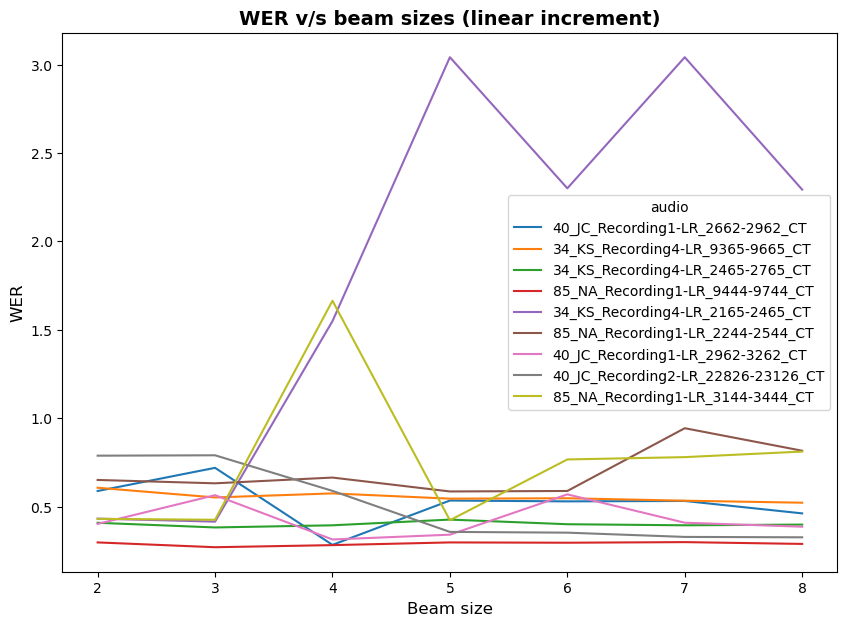

In [10]:
plt.figure(figsize=(10,7))
sns.lineplot(wer_df, x='beam_size' ,y='wer', hue='audio')
plt.xlabel("Beam size",fontsize=12)
plt.ylabel("WER", fontsize=12)
plt.title("WER v/s beam sizes (linear increment)", fontsize=14,fontweight='bold')
plt.show()

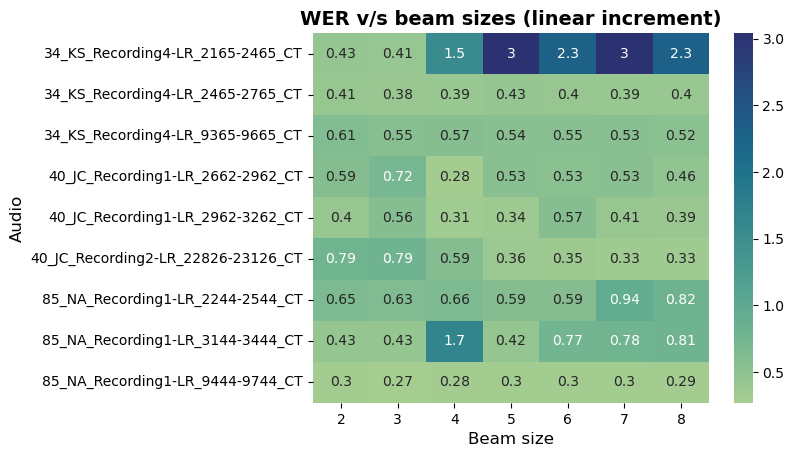

In [11]:
sns.heatmap(pivoted_df,  cmap='crest',annot=True)
plt.xlabel("Beam size",fontsize=12)
plt.ylabel("Audio", fontsize=12)
plt.title("WER v/s beam sizes (linear increment)", fontsize=14,fontweight='bold')
plt.show()

In [12]:
for beam in range(2,9):
    print(f'Beam size: {beam}  Mean WER: {wer_df[wer_df["beam_size"]==beam]["wer"].mean()}')

Beam size: 2  Mean WER: 0.5112817724473105
Beam size: 3  Mean WER: 0.5275288854019712
Beam size: 4  Mean WER: 0.7014096003306868
Beam size: 5  Mean WER: 0.727654427182318
Beam size: 6  Mean WER: 0.7052474611980277
Beam size: 7  Mean WER: 0.8064926106472082
Beam size: 8  Mean WER: 0.7001300708941228


## Comparing beam sizes which are powers of 2

In [13]:
TIMESTAMPS_TO_COMPARE = ['1726186818beam2','1726186818beam4', '1726186818beam8', '1726186818beam16', '1726186818beam32']

In [14]:
timestamps = []
audios = []
codebases = []
wers = []
beams = []

for timestamp in TIMESTAMPS_TO_COMPARE:
    time_directory = os.path.join(RESULT_DIR, timestamp)
    for codebase_name in os.listdir(time_directory):
        codebase_folder = os.path.join(time_directory, codebase_name)
        for file_name in glob.glob(codebase_folder+'/*.csv'):
            wer  = werCompute(file_name, codebase_name)
            audioname = os.path.basename(file_name)[:-4]
            timestamps.append(timestamp)
            audios.append(audioname)
            codebases.append(codebase_name)
            wers.append(wer)
            jsonpath = os.path.join(codebase_folder, audioname+'.json')
            with open(jsonpath) as f:
                jsondict = json.load(f)
            beams.append(jsondict[0]['parameters']['beam_size'])
                
wer_df = pd.DataFrame({'timestamp': timestamps, 'audio': audios, 'codebase': codebases, 'wer': wers, 'beam_size': beams})

Text(0.5, 1.0, 'WER v/s beam sizes (exponential increment)')

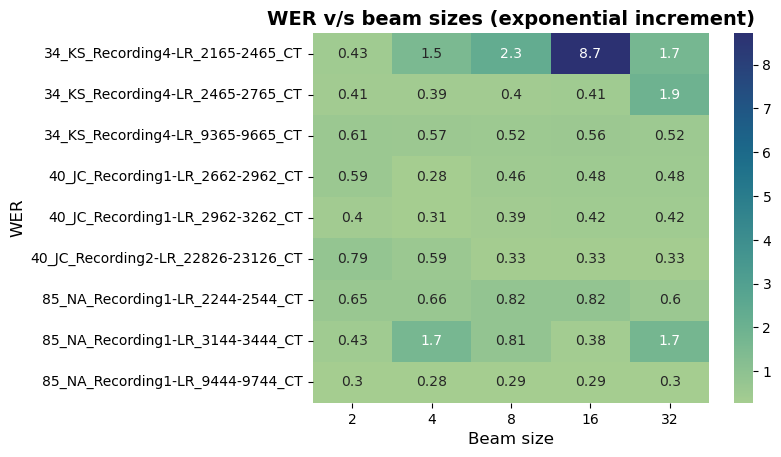

In [15]:
wer_df['beam_size'] = wer_df['beam_size'].astype(int)
pivoted_df = wer_df.pivot(index='audio', columns='beam_size', values='wer')
sns.heatmap(pivoted_df,  cmap='crest',annot=True)
plt.xlabel("Beam size",fontsize=12)
plt.ylabel("WER", fontsize=12)
plt.title("WER v/s beam sizes (exponential increment)", fontsize=14,fontweight='bold')

In [16]:
for beam in  [2,4,8,16,32]:
    print(f'Beam size: {beam}  Mean WER: {wer_df[wer_df["beam_size"]==beam]["wer"].mean()}')

Beam size: 2  Mean WER: 0.5112817724473107
Beam size: 4  Mean WER: 0.7014096003306867
Beam size: 8  Mean WER: 0.7001300708941228
Beam size: 16  Mean WER: 1.379235841349453
Beam size: 32  Mean WER: 0.8895622225888642


Beam size: 2  Mean WER: 0.5427432536847071
Beam size: 4  Mean WER: 0.5894922909379933
Beam size: 8  Mean WER: 0.7537929185944632
Beam size: 16  Mean WER: 1.152197802999725
Beam size: 32  Mean WER: 1.0561479904230284


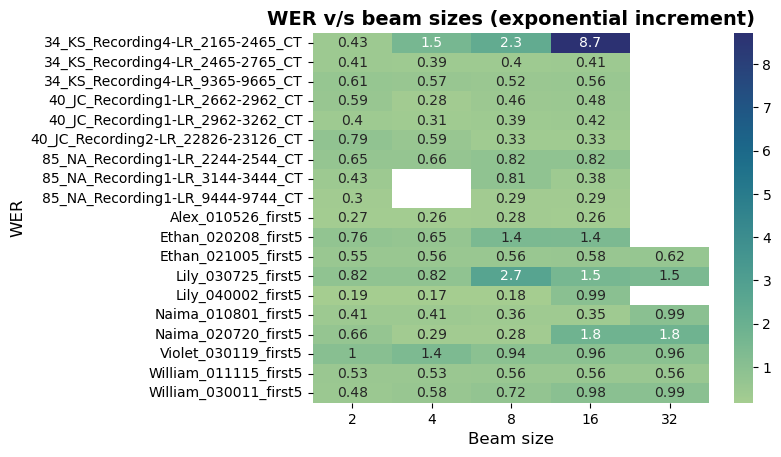

In [17]:
TIMESTAMPS_TO_COMPARE = ['1726296921beam2','1726296921beam4', '1726296921beam8', '1726296921beam16', '1726296921beam32']
timestamps = []
audios = []
codebases = []
wers = []
beams = []

for timestamp in TIMESTAMPS_TO_COMPARE:
    time_directory = os.path.join(RESULT_DIR, timestamp)
    for codebase_name in os.listdir(time_directory):
        codebase_folder = os.path.join(time_directory, codebase_name)
        for file_name in glob.glob(codebase_folder+'/*.csv'):
            wer  = werCompute(file_name, codebase_name)
            audioname = os.path.basename(file_name)[:-4]
            timestamps.append(timestamp)
            audios.append(audioname)
            codebases.append(codebase_name)
            wers.append(wer)
            jsonpath = os.path.join(codebase_folder, audioname+'.json')
            with open(jsonpath) as f:
                jsondict = json.load(f)
            beams.append(jsondict[0]['parameters']['beam_size'])
                
wer_df = pd.DataFrame({'timestamp': timestamps, 'audio': audios, 'codebase': codebases, 'wer': wers, 'beam_size': beams})
wer_df['beam_size'] = wer_df['beam_size'].astype(int)
pivoted_df = wer_df.pivot(index='audio', columns='beam_size', values='wer')
sns.heatmap(pivoted_df,  cmap='crest',annot=True)
plt.xlabel("Beam size",fontsize=12)
plt.ylabel("WER", fontsize=12)
plt.title("WER v/s beam sizes (exponential increment)", fontsize=14,fontweight='bold')

for beam in  [2,4,8,16,32]:
    print(f'Beam size: {beam}  Mean WER: {wer_df[wer_df["beam_size"]==beam]["wer"].mean()}')

In [3]:
from matplotlib.patches import Rectangle

def analyze(timestamps, parameter, special_plot_title = ""):
    TIMESTAMPS_TO_COMPARE = timestamps 
    timestamps = []
    audios = []
    codebases = []
    wers = []
    beams = []

    for timestamp in TIMESTAMPS_TO_COMPARE:
        time_directory = os.path.join(RESULT_DIR, timestamp)
        for codebase_name in os.listdir(time_directory):
            codebase_folder = os.path.join(time_directory, codebase_name)
            for file_name in glob.glob(codebase_folder+'/*.csv'):
                wer  = werCompute(file_name, codebase_name)
                audioname = os.path.basename(file_name)[:-4]
                timestamps.append(timestamp)
                audios.append(audioname)
                codebases.append(codebase_name)
                wers.append(wer)
                jsonpath = os.path.join(codebase_folder, audioname+'.json')
                with open(jsonpath) as f:
                    jsondict = json.load(f)
                beams.append(jsondict[0]['parameters'][parameter])
                    
    wer_df = pd.DataFrame({'timestamp': timestamps, 'audio': audios, 'codebase': codebases, 'wer': wers, parameter: beams})
    wer_df[parameter] = wer_df[parameter].astype(float)

    wer_df = wer_df.sort_values(by = 'audio', axis=0, ascending=True)
    
    pivoted_df = wer_df.pivot(index='audio', columns=parameter, values='wer')
    ax = sns.heatmap(pivoted_df,  cmap='crest',annot=True)
    
    row_min = pivoted_df.idxmin(axis=1)

    for row, index in enumerate(pivoted_df.index):
        position = pivoted_df.columns.get_loc(row_min[index])
        ax.add_patch(Rectangle((position, row),1,1, fill=False, edgecolor='blue', lw=1.5))

    plt.xlabel(parameter,fontsize=12)
    plt.ylabel("WER", fontsize=12)

    if special_plot_title =="":
        plt.title("WER v/s " + parameter  , fontsize=12,fontweight='bold')
    else:
        plt.title(special_plot_title, fontsize=12,fontweight='bold')

    for patience in set(list(wer_df[parameter])):
        print(parameter + f' : {patience}  Mean WER: {wer_df[wer_df[parameter]==patience]["wer"].mean()}')
    
    link_to_file = os.path.join(PLOTS_DIR,  timestamp+"_"+parameter+".pdf")
    plt.savefig(link_to_file,bbox_inches='tight') 
    return wer_df

patience : 0.5  Mean WER: 1.1853701243725674
patience : 1.0  Mean WER: 0.8051428485217117
patience : 2.0  Mean WER: 0.9521591490281822
patience : 4.0  Mean WER: 1.0204954096484073


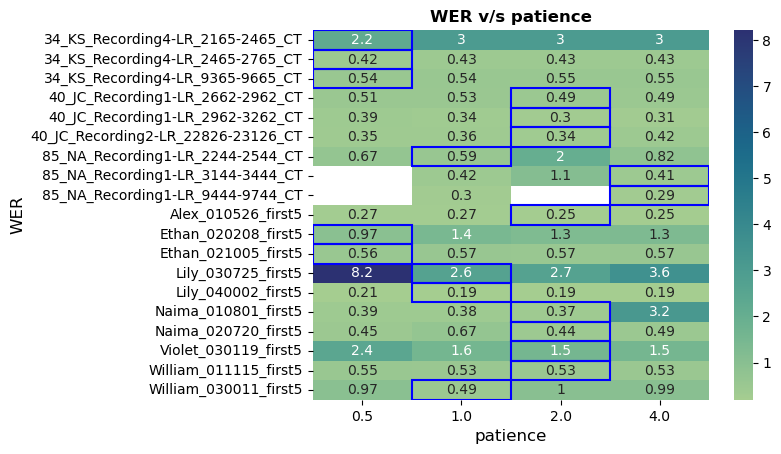

In [80]:
TIMESTAMPS_TO_COMPARE = ['1726299317patience0.5beam5','1726299317patience1beam5', '1726299317patience2beam5', '1726299317patience4beam5']

analyze(TIMESTAMPS_TO_COMPARE, 'patience')

patience : 0.5  Mean WER: 1.1442118519229807
patience : 1.0  Mean WER: 0.8051428485217117
patience : 2.0  Mean WER: 0.9167895003124641
patience : 4.0  Mean WER: 1.0204954096484073


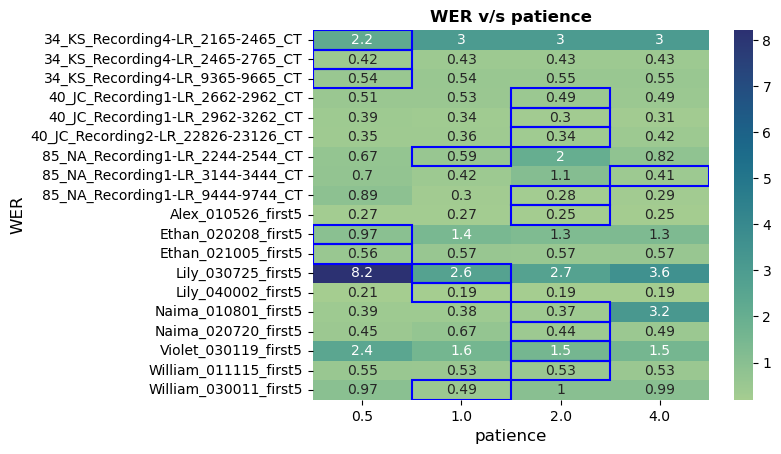

In [16]:
TIMESTAMPS_TO_COMPARE = ['1726302495patience0.5beam5','1726302495patience1beam5', '1726302495patience2beam5', '1726302495patience4beam5']

analyze(TIMESTAMPS_TO_COMPARE, 'patience')

patience : 0.5  Mean WER: 1.1442118519229807
patience : 1.0  Mean WER: 0.8051428485217117
patience : 2.0  Mean WER: 0.9167895003124641
patience : 4.0  Mean WER: 1.0204954096484073


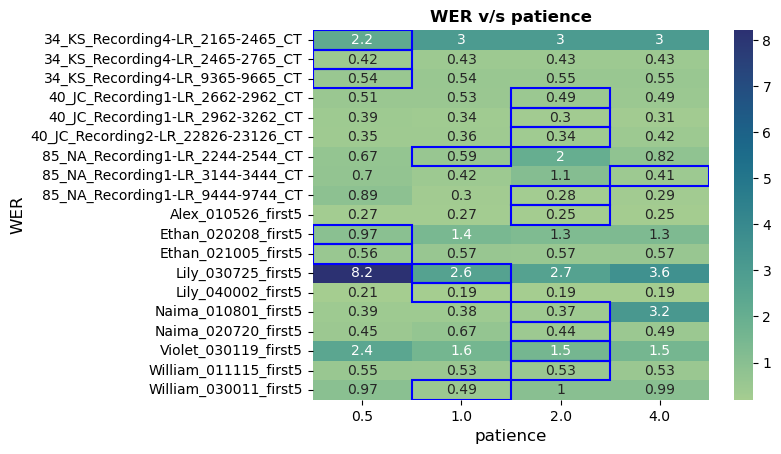

In [19]:
TIMESTAMPS_TO_COMPARE = ['1726302495patience0.5beam5','1726302495patience1beam5', '1726302495patience2beam5', '1726302495patience4beam5']

analyze(TIMESTAMPS_TO_COMPARE, 'patience')

In [4]:
def getFeatures(df, patience=None, beam_size=None, temp=None):
    df.reset_index(inplace=True,drop=True)
    dataset_name = []
    age_mos= []
    n_rows = len(df)
    for i in range(0,n_rows):
        if  df['audio'][i][-2:]=='CT':
            dataset_name.append('LENA')
            age = int(df['audio'][i] [:2])
            age_mos.append(age)
        else:
            dataset_name.append('Providence')
            underscore_pos = df['audio'][i].find("_")
            age_string = df['audio'][i] [underscore_pos+1:underscore_pos+7]
            age = int(age_string[:2])*12 + int(age_string[2:4]) + int(age_string[4:6])/30.5
            age_mos.append(age)
    
    df['dataset'] = dataset_name
    df['age_in_months'] = age_mos
    if 'temperature' not in  df.columns:
        df['temperature'] = temp

    if 'patience' not in df.columns :
        df['patience'] = patience

    if 'beam_size' not in  df.columns :
        df['beam_size'] = beam_size
    return df
    
    

In [49]:
getFeatures(res)

,level_0,index,timestamp,audio,codebase,wer,patience,dataset,age_in_months,temperature,beam_size
0,0,37,1726302495patience1beam5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,3.041463,1.0,LENA,34.000000,None,None
1,1,65,1726302495patience4beam5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,3.041463,4.0,LENA,34.000000,None,None
2,2,49,1726302495patience2beam5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,3.041463,2.0,LENA,34.000000,None,None
3,3,13,1726302495patience0.5beam5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,2.234146,0.5,LENA,34.000000,None,None
4,4,70,1726302495patience4beam5,34_KS_Recording4-LR_2465-2765_CT,yinruiqing,0.426263,4.0,LENA,34.000000,None,None
...,...,...,...,...,...,...,...,...,...,...,...
71,71,44,1726302495patience2beam5,William_011115_first5,yinruiqing,0.527233,2.0,Providence,23.491803,None,None
72,72,43,1726302495patience2beam5,William_030011_first5,yinruiqing,1.003226,2.0,Providence,36.360656,None,None
73,73,64,1726302495patience4beam5,William_030011_first5,yinruiqing,0.985484,4.0,Providence,36.360656,None,None
74,74,25,1726302495patience1beam5,William_030011_first5,yinruiqing,0.491935,1.0,Providence,36.360656,None,None


beam_size : 32.0  Mean WER: 0.9082380224244289
beam_size : 2.0  Mean WER: 0.5427432536847071
beam_size : 4.0  Mean WER: 0.6298549766839661
beam_size : 8.0  Mean WER: 0.7537929185944632
beam_size : 16.0  Mean WER: 1.1521978029997253


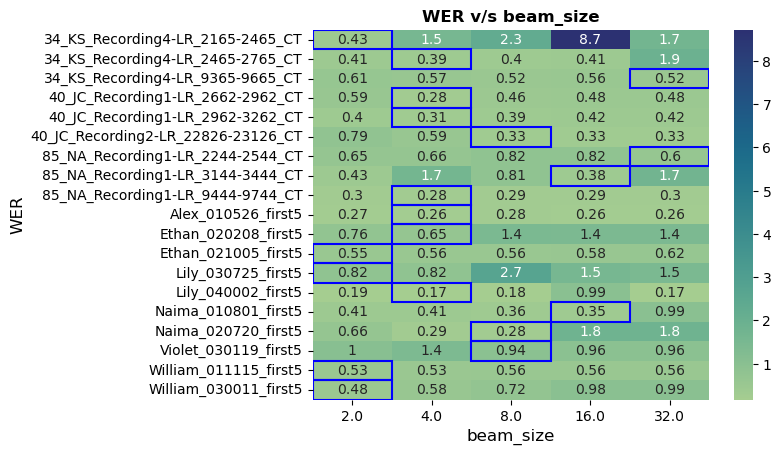

In [15]:
TIMESTAMPS_TO_COMPARE = ['1726522808beam2','1726522808beam4', '1726522808beam8', '1726522808beam16','1726522808beam32']

analyze(TIMESTAMPS_TO_COMPARE, 'beam_size')

temperature : 0.25  Mean WER: 0.5239352633403719
temperature : 0.5  Mean WER: 0.548206266053696
temperature : 0.0  Mean WER: 0.8051428485217117
temperature : 0.75  Mean WER: 0.4998875310192865


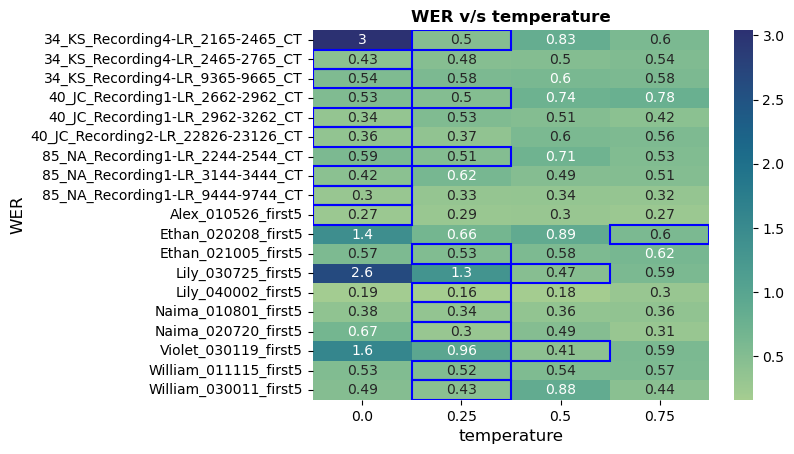

In [14]:
TIMESTAMPS_TO_COMPARE = ['1727567827temp0','1727567827temp0.25', '1727567827temp0.5', '1727567827temp0.75']

analyze(TIMESTAMPS_TO_COMPARE, 'temperature')

temperature : 0.75  Mean WER: 0.4938502409245062


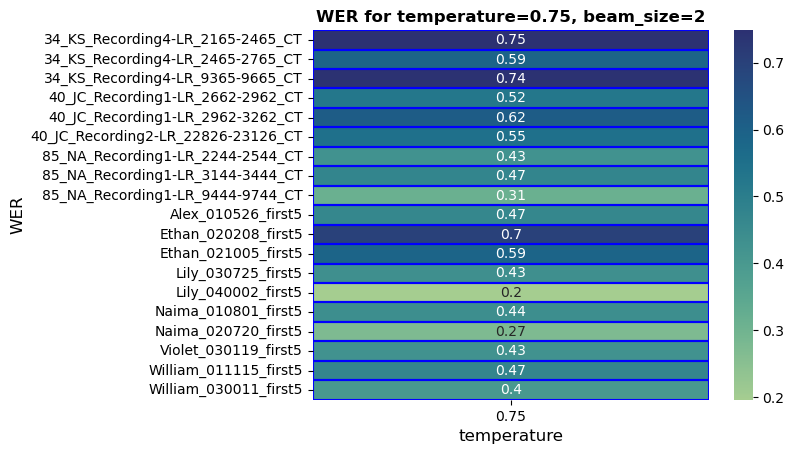

In [19]:
TIMESTAMPS_TO_COMPARE = ['1727752052temp0.75beam2']

analyze(TIMESTAMPS_TO_COMPARE, 'temperature', "WER for temperature=0.75, beam_size=2")

beam_size : 1.0  Mean WER: 0.513170440743092
beam_size : 5.0  Mean WER: 0.8051428485217117


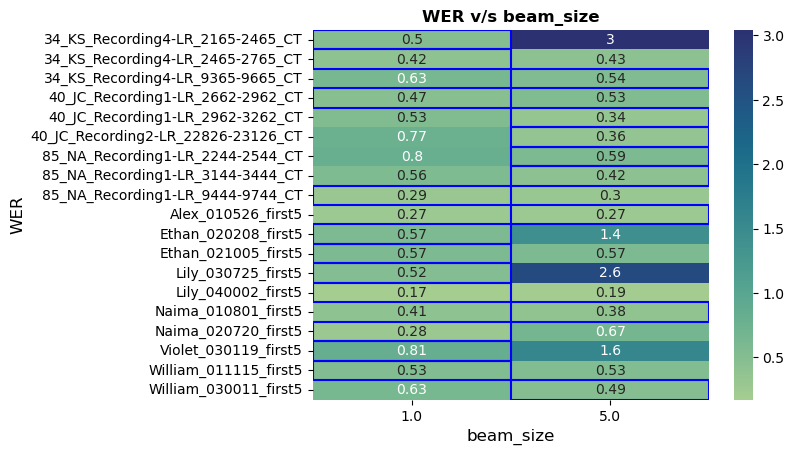

In [22]:
TIMESTAMPS_TO_COMPARE = ['1727760128temp0beam1','1727760128temp0beam5']
analyze(TIMESTAMPS_TO_COMPARE, 'beam_size')

temperature : 0.0  Mean WER: 0.575098900513506


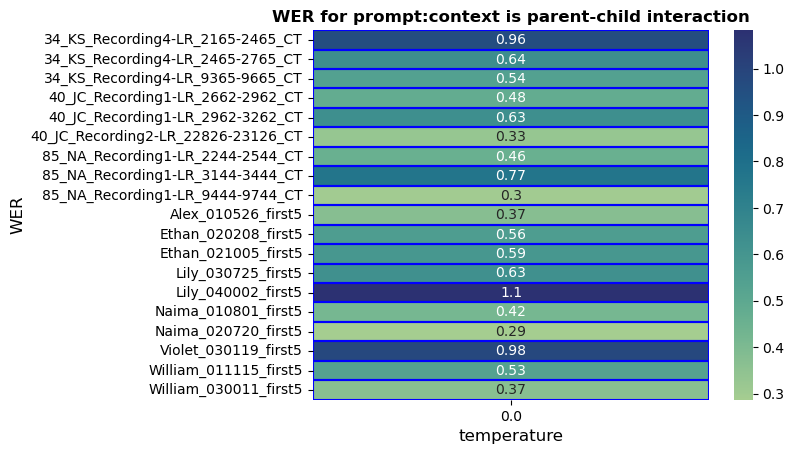

In [23]:
TIMESTAMPS_TO_COMPARE = ['1727762057']
analyze(TIMESTAMPS_TO_COMPARE, 'temperature', "WER for prompt:context is parent-child interaction")

### Running a mixed effects model

patience : 0.5  Mean WER: 1.1442118519229807
patience : 1.0  Mean WER: 0.8051428485217117
patience : 2.0  Mean WER: 0.9167895003124641
patience : 4.0  Mean WER: 1.0204954096484073


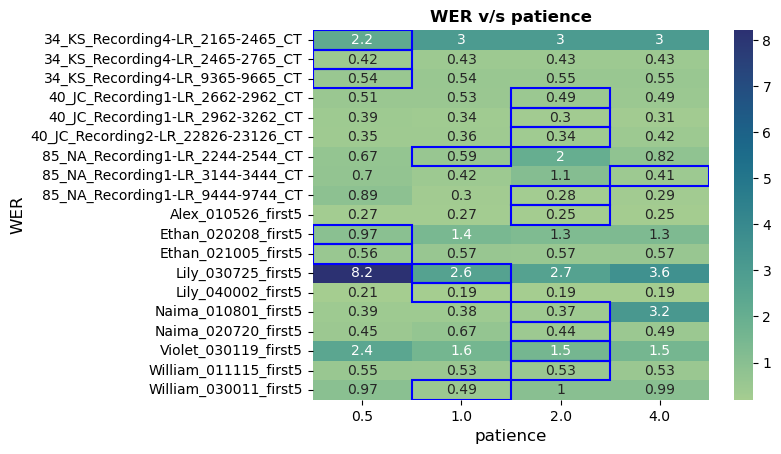

In [5]:
TIMESTAMPS_TO_COMPARE = ['1726302495patience0.5beam5','1726302495patience1beam5', '1726302495patience2beam5', '1726302495patience4beam5']

patience_varied = analyze(TIMESTAMPS_TO_COMPARE, 'patience')

In [6]:
TIMESTAMPS_TO_COMPARE = ['1726302495patience0.5beam5','1726302495patience1beam5', '1726302495patience2beam5', '1726302495patience4beam5']

patience_varied = analyze(TIMESTAMPS_TO_COMPARE, 'patience')
featurized_df = getFeatures(patience_varied, beam_size=5, temp=0)
featurized_df

,timestamp,audio,codebase,wer,patience,dataset,age_in_months,temperature,beam_size
0,1726302495patience1beam5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,3.041463,1.0,LENA,34.000000,0,5
1,1726302495patience4beam5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,3.041463,4.0,LENA,34.000000,0,5
2,1726302495patience2beam5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,3.041463,2.0,LENA,34.000000,0,5
3,1726302495patience0.5beam5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,2.234146,0.5,LENA,34.000000,0,5
4,1726302495patience4beam5,34_KS_Recording4-LR_2465-2765_CT,yinruiqing,0.426263,4.0,LENA,34.000000,0,5
...,...,...,...,...,...,...,...,...,...
71,1726302495patience2beam5,William_011115_first5,yinruiqing,0.527233,2.0,Providence,23.491803,0,5
72,1726302495patience2beam5,William_030011_first5,yinruiqing,1.003226,2.0,Providence,36.360656,0,5
73,1726302495patience4beam5,William_030011_first5,yinruiqing,0.985484,4.0,Providence,36.360656,0,5
74,1726302495patience1beam5,William_030011_first5,yinruiqing,0.491935,1.0,Providence,36.360656,0,5


In [70]:
model = smf.mixedlm('wer ~ patience +  age_in_months ', data=featurized_df, groups=featurized_df["dataset"])

In [71]:
result = model.fit()

In [72]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: wer      
No. Observations: 76      Method:             REML     
No. Groups:       2       Scale:              1.4283   
Min. group size:  36      Log-Likelihood:     -126.6389
Max. group size:  40      Converged:          Yes      
Mean group size:  38.0                                 
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.944    0.458 2.061 0.039  0.046  1.841
patience       0.001    0.102 0.007 0.994 -0.200  0.201
age_in_months  0.001    0.009 0.061 0.952 -0.016  0.018
Group Var      0.035    0.103                          
=======================================================

"""

In [84]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Convert the DataFrame to an R DataFrame
rdf = pandas2ri.py2rpy(featurized_df)
base = importr('base')
utils = importr('utils')
lme4 = importr('lme4')
ro.globalenv['rdf'] = rdf

# R code as a string
r_code = """
library(lme4)
model <- lmer(wer ~ patience +  age_in_months   +  (1|dataset)  , data=rdf)
summary(model)
 
"""

# Run the R code
r_summary = ro.r(r_code)


In [85]:
print(r_summary)

Linear mixed model fit by REML ['lmerMod']
Formula: wer ~ patience + age_in_months + (1 | dataset)
   Data: rdf

REML criterion at convergence: 253.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7223 -0.4657 -0.3801 -0.0317  5.9928 

Random effects:
 Groups   Name        Variance Std.Dev.
 dataset  (Intercept) 0.03473  0.1864  
 Residual             1.42828  1.1951  
Number of obs: 76, groups:  dataset, 2

Fixed effects:
               Estimate Std. Error t value
(Intercept)   0.9437933  0.4103126   2.300
patience      0.0007458  0.1022682   0.007
age_in_months 0.0005268  0.0073232   0.072

Correlation of Fixed Effects:
            (Intr) patinc
patience    -0.467       
age_n_mnths -0.753  0.000



In [ ]:
#For downloading packages

import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)  # Select the first CRAN mirror

# Install lme4 package
utils.install_packages('lme4')


In [ ]:
utils.install_packages('lmerTest')

In [88]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Convert the DataFrame to an R DataFrame
rdf = pandas2ri.py2rpy(featurized_df)
base = importr('base')
utils = importr('utils')
lme4 = importr('lme4')
lmerTest = importr('lmerTest')

ro.globalenv['rdf'] = rdf

# R code as a string
r_code = """
library(lmerTest)
model <- lmer(wer ~ patience +  age_in_months   +  (1|dataset)  , data=rdf)
summary(model)
"""

# Run the R code
r_summary = ro.r(r_code)


In [89]:
print(r_summary)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: wer ~ patience + age_in_months + (1 | dataset)
   Data: rdf

REML criterion at convergence: 253.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7223 -0.4657 -0.3801 -0.0317  5.9928 

Random effects:
 Groups   Name        Variance Std.Dev.
 dataset  (Intercept) 0.03473  0.1864  
 Residual             1.42828  1.1951  
Number of obs: 76, groups:  dataset, 2

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)  
(Intercept)   9.438e-01  4.103e-01 6.735e+00   2.300   0.0564 .
patience      7.458e-04  1.023e-01 7.200e+01   0.007   0.9942  
age_in_months 5.268e-04  7.323e-03 2.099e+01   0.072   0.9433  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) patinc
patience    -0.467       
age_n_mnths -0.753  0.000



In [90]:
# R code as a string
r_code = """
library(lmerTest)
model <- lmer(wer ~   age_in_months   +  (1|dataset)  +  (1|patience) , data=rdf)
summary(model)
"""

# Run the R code
r_summary2 = ro.r(r_code)

R[write to console]: boundary (singular) fit: see help('isSingular')



In [91]:
print(r_summary2)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: wer ~ age_in_months + (1 | dataset) + (1 | patience)
   Data: rdf

REML criterion at convergence: 250.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7275 -0.4701 -0.3802 -0.0330  6.0320 

Random effects:
 Groups   Name        Variance Std.Dev.
 patience (Intercept) 0.00000  0.0000  
 dataset  (Intercept) 0.03544  0.1883  
 Residual             1.40871  1.1869  
Number of obs: 76, groups:  patience, 4; dataset, 2

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)  
(Intercept)   9.432e-01  3.615e-01 4.217e+00   2.610   0.0564 .
age_in_months 5.713e-04  7.283e-03 2.158e+01   0.078   0.9382  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
age_n_mnths -0.850
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')




In [96]:
# R code as a string
r_code = """
library(lmerTest)
model <- lmer(wer ~ patience +  age_in_months   +  (patience+age_in_months|dataset)  , data=rdf)
summary(model)
"""

# Run the R code
r_summary3 = ro.r(r_code)

R[write to console]: boundary (singular) fit: see help('isSingular')



In [97]:
print(r_summary3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: wer ~ patience + age_in_months + (patience + age_in_months |  
    dataset)
   Data: rdf

REML criterion at convergence: 249.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3584 -0.4113 -0.2589  0.1179  5.7569 

Random effects:
 Groups   Name          Variance Std.Dev. Corr       
 dataset  (Intercept)   0.810921 0.90051             
          patience      0.000146 0.01208   0.96      
          age_in_months 0.001154 0.03397  -1.00 -0.97
 Residual               1.323376 1.15038             
Number of obs: 76, groups:  dataset, 2

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)
(Intercept)    0.437644   0.767041  0.972875   0.571    0.672
patience       0.001141   0.098811 33.956907   0.012    0.991
age_in_months  0.017754   0.026038  0.882802   0.682    0.631

Correlation of Fixed Effects:
            (Intr) patinc
patience    -0.171       
age

In [9]:
featurized_df

,timestamp,audio,codebase,wer,patience,dataset,age_in_months,temperature,beam_size
0,1726302495patience1beam5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,3.041463,1.0,LENA,34.000000,0,5
1,1726302495patience4beam5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,3.041463,4.0,LENA,34.000000,0,5
2,1726302495patience2beam5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,3.041463,2.0,LENA,34.000000,0,5
3,1726302495patience0.5beam5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,2.234146,0.5,LENA,34.000000,0,5
4,1726302495patience4beam5,34_KS_Recording4-LR_2465-2765_CT,yinruiqing,0.426263,4.0,LENA,34.000000,0,5
...,...,...,...,...,...,...,...,...,...
71,1726302495patience2beam5,William_011115_first5,yinruiqing,0.527233,2.0,Providence,23.491803,0,5
72,1726302495patience2beam5,William_030011_first5,yinruiqing,1.003226,2.0,Providence,36.360656,0,5
73,1726302495patience4beam5,William_030011_first5,yinruiqing,0.985484,4.0,Providence,36.360656,0,5
74,1726302495patience1beam5,William_030011_first5,yinruiqing,0.491935,1.0,Providence,36.360656,0,5


In [37]:
model = smf.mixedlm("wer ~ age_in_months + patience",
                    featurized_df,
                    groups=featurized_df["patience"])
                    #re_formula="~age_in_months")  # Random slopes by phoneme
result = model.fit()

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/base/model.py:

In [38]:
print(result.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: wer      
No. Observations:  76      Method:             REML     
No. Groups:        4       Scale:              1.4414   
Min. group size:   19      Log-Likelihood:     -126.7157
Max. group size:   19      Converged:          No       
Mean group size:   19.0                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.039    0.372  2.791 0.005  0.309  1.769
age_in_months -0.002    0.007 -0.240 0.810 -0.015  0.012
patience       0.001    0.103  0.007 0.994 -0.201  0.202
Group Var      0.000                                    



In [35]:
featurized_df['fitted_wer'] = result.fittedvalues

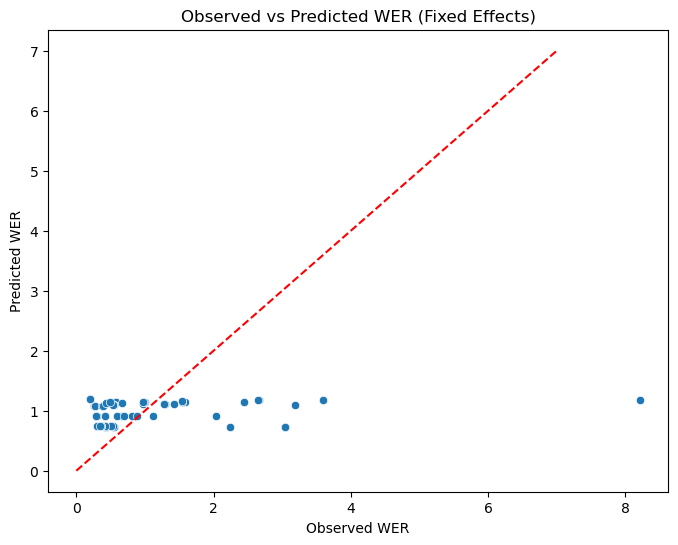

In [36]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='wer', y='fitted_wer', data=featurized_df)
plt.plot([0, 7], [0, 7], '--', color='red')
plt.title('Observed vs Predicted WER (Fixed Effects)')
plt.xlabel('Observed WER')
plt.ylabel('Predicted WER')
plt.show()

temperature : 0.25  Mean WER: 0.5239352633403719
temperature : 0.5  Mean WER: 0.548206266053696
temperature : 0.0  Mean WER: 0.8051428485217117
temperature : 0.75  Mean WER: 0.4998875310192865


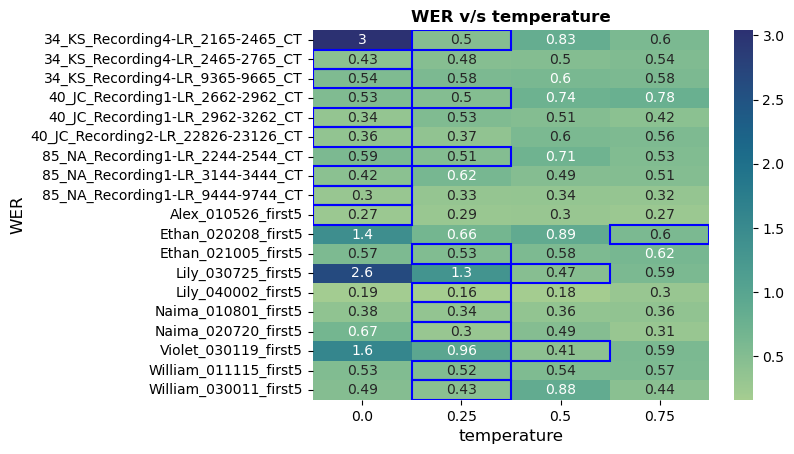

In [39]:
TIMESTAMPS_TO_COMPARE = ['1727567827temp0','1727567827temp0.25', '1727567827temp0.5', '1727567827temp0.75']

temp_varied = analyze(TIMESTAMPS_TO_COMPARE, 'temperature')
featurized_temp = getFeatures(temp_varied, patience=1, beam_size=5)

In [40]:
featurized_temp

,timestamp,audio,codebase,wer,temperature,dataset,age_in_months,patience,beam_size
0,1727567827temp0.25,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,0.495122,0.25,LENA,34.000000,1,5
1,1727567827temp0.5,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,0.826829,0.50,LENA,34.000000,1,5
2,1727567827temp0,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,3.041463,0.00,LENA,34.000000,1,5
3,1727567827temp0.75,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,0.597561,0.75,LENA,34.000000,1,5
4,1727567827temp0,34_KS_Recording4-LR_2465-2765_CT,yinruiqing,0.426263,0.00,LENA,34.000000,1,5
...,...,...,...,...,...,...,...,...,...
71,1727567827temp0.25,William_011115_first5,yinruiqing,0.522876,0.25,Providence,23.491803,1,5
72,1727567827temp0.75,William_030011_first5,yinruiqing,0.438710,0.75,Providence,36.360656,1,5
73,1727567827temp0.5,William_030011_first5,yinruiqing,0.877419,0.50,Providence,36.360656,1,5
74,1727567827temp0.25,William_030011_first5,yinruiqing,0.433871,0.25,Providence,36.360656,1,5


In [46]:
model = smf.mixedlm("wer ~ age_in_months + temperature",
                    featurized_temp,
                    groups=featurized_df["dataset"],
                    re_formula="~age_in_months+ temperature")  
result = model.fit()

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [47]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       wer     
No. Observations:         76            Method:                   REML    
No. Groups:               2             Scale:                    0.1878  
Min. group size:          36            Log-Likelihood:           -56.6192
Max. group size:          40            Converged:                Yes     
Mean group size:          38.0                                            
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.704    0.194  3.619 0.000  0.323  1.085
age_in_months                    0.002    0.340  0.004 0.996 -0.664  0.667
temperature                     -0.350    0.221 -1.584 0.113 -0.783  0.083
Group Var                        0.020    0.224                           
Group x age_in_months Cov       -0.002    0.279                           
age_in_months Var                0.231                                    
Group x temperature Cov          0.025    0.013                           
age_in_months x temperature Cov  0.002                                    
temperature Var                  0.034    0.193                           
==========================================================================

"""

In [48]:
random_effects = result.random_effects

In [50]:
print(random_effects)

{'LENA': Group            0.093106
age_in_months   -0.004116
temperature      0.122292
dtype: float64, 'Providence': Group           -0.093106
age_in_months    0.004116
temperature     -0.122292
dtype: float64}


In [52]:
featurized_temp['fitted_wer'] = result.fittedvalues

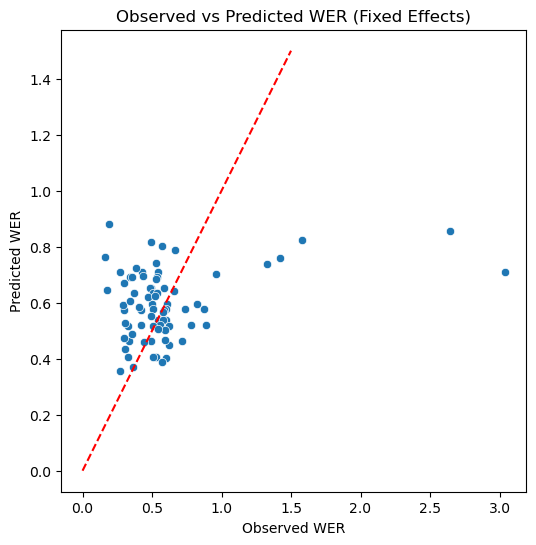

In [58]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='wer', y='fitted_wer', data=featurized_temp)
plt.plot([0, 1.5], [0,1.5], '--', color='red')
plt.title('Observed vs Predicted WER (Fixed Effects)')
plt.xlabel('Observed WER')
plt.ylabel('Predicted WER')
plt.show()

In [61]:
for dataset in random_effects:
    featurized_temp.loc[featurized_temp['dataset'] == dataset, 'fitted_wer'] += (
        random_effects[dataset]['age_in_months'] * featurized_temp.loc[featurized_temp['dataset'] == dataset, 'age_in_months'] +
        random_effects[dataset]['temperature'] * featurized_temp.loc[featurized_temp['dataset'] == dataset, 'temperature']
    )

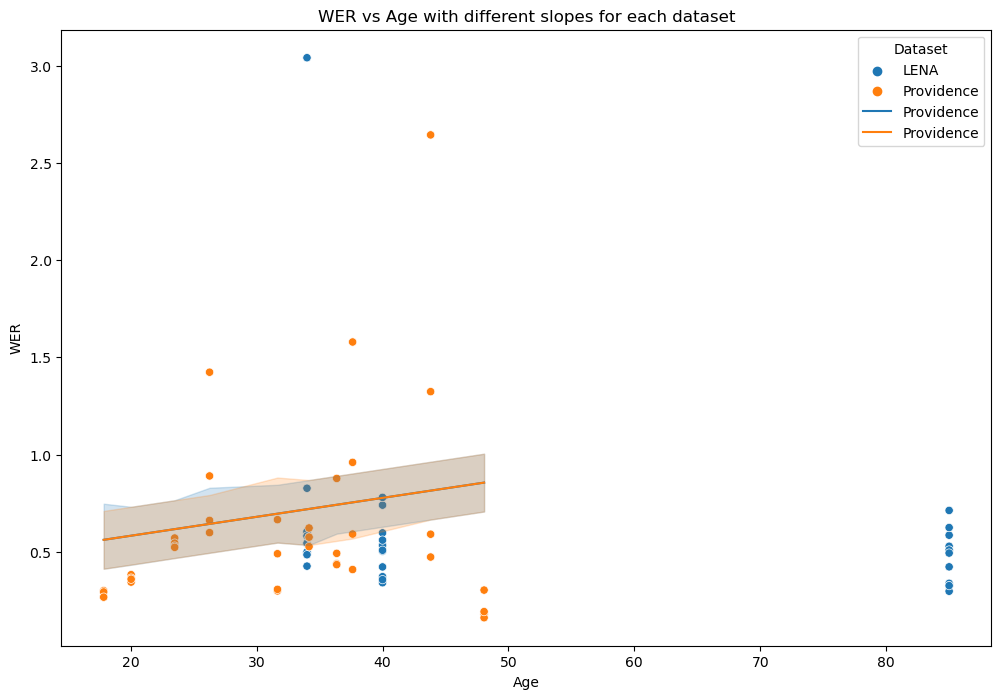

In [65]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=featurized_temp, x='age_in_months', y='wer', hue='dataset', palette='tab10')

# Plot the regression lines for each group
for session in featurized_temp['dataset'].unique():
    session_data = featurized_temp[featurized_temp['dataset'] == dataset]
    sns.lineplot(x=session_data['age_in_months'], y=session_data['fitted_wer'], label=dataset)

plt.xlabel('Age')
plt.ylabel('WER')
plt.title('WER vs Age with different slopes for each dataset')
plt.legend(title='Dataset')
plt.show()


In [69]:
null_model = smf.mixedlm("wer ~ 1", featurized_temp, groups=featurized_temp["dataset"], re_formula="~age_in_months+ temperature")
null_result = null_model.fit()


llf_full =  result.llf
llf_null = null_result.llf


lr_statistic = -2 * (llf_null - llf_full)


df_diff = (len(result.params) - len(null_result.params))


from scipy.stats import chi2

p_value = chi2.sf(lr_statistic, df_diff)

print("Likelihood Ratio Statistic:", lr_statistic)
print("Degrees of Freedom:", df_diff)
print("p-value:", p_value)

Likelihood Ratio Statistic: -16.477574941552803
Degrees of Freedom: 2
p-value: 1.0


/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


## Running a mixed effects model for all these experiments combined

In [ ]:
TIMESTAMPS_TO_COMPARE = ['1727567827temp0','1727567827temp0.25', '1727567827temp0.5', '1727567827temp0.75']
temp_varied = analyze(TIMESTAMPS_TO_COMPARE, 'temperature')
featurized_temp = getFeatures(temp_varied, patience=1, beam_size=5)
featurized_temp = featurized_temp[['timestamp', 'audio', 'codebase', 'wer', 'dataset',
       'age_in_months', 'temperature', 'patience','beam_size']]

TIMESTAMPS_TO_COMPARE = ['1726302495patience0.5beam5','1726302495patience1beam5', '1726302495patience2beam5', '1726302495patience4beam5']
patience_varied = analyze(TIMESTAMPS_TO_COMPARE, 'patience')
featurized_patience = getFeatures(patience_varied, beam_size=5, temp=0)
featurized_patience=featurized_patience[['timestamp', 'audio', 'codebase', 'wer', 'dataset',
       'age_in_months', 'temperature', 'patience','beam_size']]

TIMESTAMPS_TO_COMPARE = ['1726522808beam2','1726522808beam4', '1726522808beam8', '1726522808beam16','1726522808beam32']
beam_varied = analyze(TIMESTAMPS_TO_COMPARE, 'beam_size')
featurized_beam = getFeatures(beam_varied, patience=1, temp=0)
featurized_beam=featurized_beam[['timestamp', 'audio', 'codebase', 'wer', 'dataset',
       'age_in_months', 'temperature', 'patience','beam_size']]


TIMESTAMPS_TO_COMPARE = ['1727752052temp0.75beam2']
specific_beam_temp = analyze(TIMESTAMPS_TO_COMPARE, 'temperature')
featurized_specific = getFeatures(specific_beam_temp, patience=1, temp=0.75, beam_size=2)
featurized_specific=featurized_specific[['timestamp', 'audio', 'codebase', 'wer', 'dataset',
       'age_in_months', 'temperature', 'patience','beam_size']]

In [23]:
master_df = pd.concat([featurized_specific,featurized_beam,featurized_patience,featurized_temp])

Note - master_df contains data from all the experiments combined, with beamsize temp patience as features

In [25]:
master_df

,timestamp,audio,codebase,wer,dataset,age_in_months,temperature,patience,beam_size
0,1727752052temp0.75beam2,34_KS_Recording4-LR_2165-2465_CT,yinruiqing,0.748780,LENA,34.000000,0.75,1.0,2.0
1,1727752052temp0.75beam2,34_KS_Recording4-LR_2465-2765_CT,yinruiqing,0.589899,LENA,34.000000,0.75,1.0,2.0
2,1727752052temp0.75beam2,34_KS_Recording4-LR_9365-9665_CT,yinruiqing,0.743707,LENA,34.000000,0.75,1.0,2.0
3,1727752052temp0.75beam2,40_JC_Recording1-LR_2662-2962_CT,yinruiqing,0.524590,LENA,40.000000,0.75,1.0,2.0
4,1727752052temp0.75beam2,40_JC_Recording1-LR_2962-3262_CT,yinruiqing,0.616253,LENA,40.000000,0.75,1.0,2.0
...,...,...,...,...,...,...,...,...,...
71,1727567827temp0.25,William_011115_first5,yinruiqing,0.522876,Providence,23.491803,0.25,1.0,5.0
72,1727567827temp0.75,William_030011_first5,yinruiqing,0.438710,Providence,36.360656,0.75,1.0,5.0
73,1727567827temp0.5,William_030011_first5,yinruiqing,0.877419,Providence,36.360656,0.50,1.0,5.0
74,1727567827temp0.25,William_030011_first5,yinruiqing,0.433871,Providence,36.360656,0.25,1.0,5.0


In [45]:
everything_model = smf.mixedlm("wer ~ age_in_months + temperature + patience + beam_size",
                    master_df,
                    groups=master_df["dataset"] ,
                    re_formula="~ age_in_months + temperature+ patience + beam_size")  
result = everything_model.fit()

''' fixed version
everything_model = smf.mixedlm("wer ~ age_in_months + temperature + patience + beam_size",
                    master_df,
                    groups=master_df["dataset"] ,
                    re_formula="~ age_in_months + filename + dataset")  
result = everything_model.fit()
'''

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [46]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                   MixedLM       Dependent Variable:       wer      
No. Observations:        266           Method:                   REML     
No. Groups:              2             Scale:                    0.7708   
Min. group size:         126           Log-Likelihood:           -357.1874
Max. group size:         140           Converged:                Yes      
Mean group size:         133.0                                            
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.543    0.349  1.558 0.119 -0.140  1.226
age_in_months                    0.006    0.015  0.427 0.669 -0.023  0.035
temperature                     -0.440    0.240 -1.835 0.067 -0.909  0.030
patience                         0.056    0.073  0.771 0.441 -0.086  0.199
beam_size                        0.009    0.014  0.617 0.537 -0.019  0.036
Group Var                        0.158    0.307                           
Group x age_in_months Cov       -0.005    0.011                           
age_in_months Var                0.000    0.000                           
Group x temperature Cov          0.045    0.102                           
age_in_months x temperature Cov -0.001    0.002                           
temperature Var                  0.030                                    
Group x patience Cov            -0.015    0.055                           
age_in_months x patience Cov     0.000    0.001                           
temperature x patience Cov      -0.005                                    
patience Var                     0.001                                    
Group x beam_size Cov            0.001    0.009                           
age_in_months x beam_size Cov   -0.000                                    
temperature x beam_size Cov      0.001                                    
patience x beam_size Cov        -0.000                                    
beam_size Var                    0.000                                    
==========================================================================

"""